In [18]:
import torch
import torch.nn as nn
from torch import Tensor
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import math
import numpy as np
import torch.nn.functional as F
from datetime import datetime

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

# The 'An Image is Worth 16x16 Words' Vision Transformer
*Created using the walkthrough from https://medium.com/pytorch/training-compact-transformers-from-scratch-in-30-minutes-with-pytorch-ff5c21668ed5 and Dr Prashant's Vision_Transformer file

## Building the Transformer block by block

### Every part/layer of the transformer is built using the Pytorch nn.module class which allows for easy creation of maching learning models. Each layer should be made up of at least two parts: An initialization function which uses the given information to build the class and then the 'Forward' function defines how the class will run when it is called.

### First, the actual ViT Class which essentially acts as a hub. It ensures that each part of the transformer is called in the correct order and that local variables can be passed along.

In [19]:
class ViT(nn.Module):
    '''
    Simplified implementation of the Vision transformer.

    Parameters
    ----------
    img_size: int
        Both height and width of the image (if it is a square)
    in_channels: int
        Number of input channels
    patch_size: int
        Both height and width of the patch (if it is a square)
    embed_dim: int
        The embedding size for each token
    n_layers: int
        Number of transformer blocks
    n_heads: int
        Number of attention heads
    attn_dropout, proj_dropout, mlp_dropout: float
        Dropout probability
    mlp_ratio: float
        Determine the hidden dimension of the MLP module
    qkv_bias: bool
        If true then we add bias to the query, key and value projections
    n_classes: int
        Number of classes

    Attributes
    -----------
    n_patches: int
        Number of patches that can be taken from each image based on size.
    patch_embed: PatchEmbed
        Sets up the `Patching' layer.
    class_embed: nn.Parameter
        Learnable parameter that will represent the first class token in the sequence.
        It has `embed_dim' elements.
    pos_embed: nn.Parameter
        Adds a positional encoding to every token.
    pos_drop: nn.Dropout
        Dropout layer.
    tr_block: nn.ModuleList
        Instance of 'TransformerEncoderLayer'.
    norm: nn.Layernorm
        Layer normalization.
    '''
    def __init__(self,
                 img_size=32,   # The square size of each image
                 in_channels=3, # Number of channels for each image (eg: Grayscale=1, RGB=3)
                 patch_size=4,  # The square size of each patch
                 embed_dim=42,  # Embedding dimension
                 n_layers=3, # How many times to run the transformer encoder
                 n_heads=3,   # Number of attention heads
                 attn_dropout=0.,  # Attention Dropout
                 proj_dropout=0.,   # (MHA) Projection Dropout
                 mlp_dropout=0.,   # (MHA) last layer dropout
                 mlp_ratio=4,   # (MHA) Projection FF dimension
                 qkv_bias = True,
                 n_classes=10   # Number of classes to classify
    ):
        super().__init__()
        # Provides an error if the patching size is not divisible by the image size.
        assert img_size % patch_size == 0, \
            print("Given image size ({}) has to be divisible by given patch size ({})".format(img_size, patch_size))
        n_patches = (img_size // patch_size) ** 2
        hidden_dim = int(embed_dim * mlp_ratio)
        
        self.patch_embed = Patching(
            in_channels,
            patch_size,
            embed_dim
        )

        self.class_embed = nn.Parameter(torch.zeros(1,1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, n_patches+1, embed_dim))
        # Can use this to enable Sinusoidal PE
        #self.pos_embed = PositionalEmbedding(1, n_patches + 1, embed_dim)

        self.pos_drop = nn.Dropout(p=proj_dropout)
        self.tr_block = nn.ModuleList(
            [
                TransformerEncoderLayer(
                    embed_dim,
                    n_heads,
                    qkv_bias,
                    attn_dropout,
                    proj_dropout,
                    mlp_dropout,
                    hidden_dim
                    )
                for _ in range(n_layers)
            ]   # Sends data through the encoder n times
        )
                                    
        self.norm = nn.LayerNorm(embed_dim, eps=1e-6)
        self.head = nn.Linear(embed_dim, n_classes)

    def forward(self, x):
        '''
        Defines how the class will run

        Parameters
        ----------
        x: torch.Tensor
            shape: n_samples, in_chains, img_size, img_size

        Returns
        ---------
        logits: torch.Tensor
            Logits over all the classes: n_samples, n_samples
        '''
        x = self.patch_embed(x)
        class_token = self.class_embed.expand(x.shape[0], -1, -1)
        x = torch.cat((class_token, x), dim=1)
        #x = self.pos_embed(x)
        x += self.pos_embed
        x = self.pos_drop(x)
        for tr_block in self.tr_block:
            x = tr_block(x)
        x = self.norm(x)
        x = x[:, 0]
        x = self.head(x)
        return x

### This is the sinusoidal positional encoding layer as seen in the original 'Attention is All You Need' paper. It basically uses a sin/cos waveform to provide a unique positional offset that is given to a token at the corresponding position in its embedding space. By default, this is disabled and a trainable matrix of zeros is being used instead. This will allow the patching class to also perform the positional embedding.. I think.

In [20]:
class PositionalEmbedding(nn.Module):
    '''
    Applies Learnable Sinusoidal Positional Encoding

    Parameters
    ----------
    embed_dim: int
        The positional embedding dimension (How big embedding for each patch.Constant across entire network)
    max_len: int 
        Max number of instances for positions
    freq: int 
        The base frequency for Sin/Cos calculations. Higher values (eg 10000) are more stable
    '''
    def __init__(self, 
                 embed_dim,
                 max_len=5000,
                 freq=10000.,
                ):
        super().__init__()
        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div = torch.exp(torch.arange(0, embed_dim, 2).float() *
                        (-math.log(freq) / embed_dim))
        pe[:, 0::2] = torch.sin(position * div) # Even terms
        pe[:, 1::2] = torch.cos(position * div) # Odd terms
        pe = pe.unsqueeze(0).transpose(0,1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        '''
        Defines how the class will run

        Parameters
        -----------

        Returns
        -----------
        '''
        x = x + self.pe[:x.size(0), :]
        return x

### This patching layer uses a convolutional filter to segment the input image into patch_size segments. It accomplishes this by making the kernel and stride the same size as a patch so that it moves across the image grabbing segments with no overlap. This filter can essentially act as the positional encoder too.. I think.

In [21]:
class Patching(nn.Module):
    '''
    Splits the image into patches

    Parameters
    ----------
    in_channels: int 
        Number of input channels (eg: Grayscale=1, RGB = 3)
    patch_size: int 
        Size of the patch (it is a square; it doesnt have to be) (Sometimes called kernel_size)
    embed_dim: int
        The positional embedding dimension (How big embedding for each patch.Constant across entire network)

    Attributes
    ----------
    proj: nn.Conv2d
        Convolutional layer that does both the splitting into patches and embedding
    '''
    def __init__(self,
                 in_channels=3,
                 patch_size=16,
                 embed_dim=768,
    ):

        super().__init__()

        self.proj = nn.Conv2d(
            in_channels,
            embed_dim,
            kernel_size=patch_size,
            stride=patch_size
        )

    def forward(self, x):
        '''
        Defines how the class will run

        Parameters
        -----------
        x: torch.Tensor
        Shape: (n_samples, in_channels, img_size, img_size)

        Returns
        -----------
        torch.Tensor
        Shape: (n_samples, n_patches, embed_dim)
        '''
        x = self.proj(x)
        x = x.flatten(2)
        x = x.transpose(1,2)
        return x

### This is the Transformer Encoder block which applies all of the actual normalization, attention, etc that make a Transformer what it is.

In [22]:
class TransformerEncoderLayer(nn.Module):
    '''
    Transformer Block/Encoder Layer

    Parameter
    ---------
    embed_dim: int
        embedding dimension
    n_heads: int
        number of attention heads
    mlp_ratio: float
        determines the hidden dimension size of the MLP module with respect to 'dim'
    qkv_bias: bool
        If true then we include bias to the query, key and value projections
    mlp_dropout, proj_dropout, attn_droupout: float
        dropout probability
    dim_feedforward: int
        The feature number of hidden layer of the FFN

    Attributes
    ----------
    norm_1, norm_2: LayerNorm
        Layer normalization
    MHA: Attention
        Multi-Headed Attention module
    mlp: MLP
        MLP module
    ''' 
    def __init__(self,
                 embed_dim=768,
                 n_heads=12,
                 qkv_bias=True,
                 attn_dropout=0.,
                 proj_dropout=0.,
                 mlp_dropout=0.,
                 hidden_dim=2048
    ):
        super().__init__()
        self.norm_1 = nn.LayerNorm(embed_dim, eps = 1e-6)
        self.norm_2 = nn.LayerNorm(embed_dim, eps = 1e-6)
        self.MHA = MultiheadedSelfAttention(embed_dim,
                                        n_heads,
                                        qkv_bias,
                                        attn_dropout,
                                        proj_dropout
        )
        self.MLP = MLP(embed_dim, hidden_dim, mlp_dropout)

    def forward(self, x):
        '''
        Defines how the class will run
        
        Parameter
        ---------
        x: torch.Tensor
            shape: n_samples, n_patches + 1, dim

        Returns
        --------
        torch.Tensor
            shape: n_samples, n_patches + 1, dim
        '''
        x = x + self.MHA(self.norm_1(x))    # Residual connection (Add)
        x = x + self.MLP(self.norm_2(x))    # Residual connection (Add)
        return x

### The heart of the Transformer model. The multiheaded attention layer!

In [23]:
class MultiheadedSelfAttention(nn.Module):
    '''
    Multi-Headed Attention Mechanism

    Parameters
    ----------
    embed_dim: int
        The input and out dimension of per token feature
    n_heads: int
        Number of attention heads 
    qkv_bias: bool
        if true then we include bias to the query, key and value projections
    attn_p: float
        Dropout probability applied to the query, key and value tensors.
    proj_p: float
        Dropout probability applied to output tensor
        
    Attributes
    ----------
    scale: float
        Normalizing constant for the dot product
    qkv: nn.Linear
        Linear projection for the query, key and value
    proj: nn.Linear
        Linear mapping that takes in the concatenated output of all attention
        heads and maps into the new space
    attn_drop, proj_drop: nn.Dropout
        Dropout layers.
    '''
    def __init__(self, 
                 embed_dim, 
                 n_heads=2,
                 qkv_bias = True,
                 attn_dropout=0.,
                 proj_dropout=0.
    ):
        super().__init__()
        self.n_heads = n_heads
        assert embed_dim % n_heads == 0, \
            print('Embedding dim must be divisible by number of heads.')
        self.head_dim = embed_dim // n_heads
        self.scale = self.head_dim ** -0.5
        self.dim = embed_dim
        self.qkv = nn.Linear(embed_dim, embed_dim * 3, bias=qkv_bias)
        self.attn_dropout = nn.Dropout(attn_dropout)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.proj_dropout = nn.Dropout(proj_dropout)
        
    def forward(self, x):
        '''
        Defines how the class will run
        
        Parameters
        ----------
        x: torch.Tensor
            shape: n_samples (B), n_patches + 1 (N), embed_dim (C)
            N is also equal to the number of tokens.
        Returns
        --------
        torch.Tensor
            shape: n_samples, n_patches + 1, embed_dim
        '''
        B, N, C = x.shape
        qkv = self.qkv(x)
        qkv = qkv.reshape(B, N, 3,
            self.n_heads,
            self.head_dim
            )
        qkv = qkv.permute(
            2,    # qkv (3)
            0,    # batch (n_samples)
            3,    # channel (n_heads)
            1,    # n_patches + 1
            4     # head_dim (embed_dim / n_heads)
            )
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) * self.scale # <q,k> / sqrt(d)
        attn = attn.softmax(dim=-1) # Softmax over embedding dim
        attn = self.attn_dropout(attn)

        weighted_avg = (attn @ v)
        weighted_avg = weighted_avg.transpose(1, 2)
        weighted_avg = weighted_avg.flatten(2)

        x = self.proj(weighted_avg)
        x = self.proj_dropout(x)

        return x

### The MLP layer from the end of the Transformer Encoder, not to be confused with the mlp head which adds class encodings at the very end of the transformer.

In [24]:
class MLP(nn.Module):
    '''
    Multilayer perceptron 
    
    Parameters
    ----------
    embed_dim: int
        embedding dimension
    feedforward_dim: int
      Number of nodes in the hidden layer
    mlp_dropout: float
      Dropout probability

    Attribute
    ---------
    fc: nn.Linear
      The first linear layer
    act: nn. GELU
      GELU activation function
    fc2: nn.Linear
      The second linear layer
    drop: nn.Dropout
      Dropout layer
    '''

    def __init__(self, embed_dim, hidden_dim, mlp_dropout):
        super().__init__()
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_dim, embed_dim)
        self.drop = nn.Dropout(mlp_dropout)

    def forward(self,x):
        '''
        Defines how the class will run
        
        Parameters
        ----------
        x: torch.Tensor
          shape: n_samples, n_patches + 1, in_features

        Returns
        ----------
        torch.Tensor
          n_samples, n_patches+ 1, out_features
        '''
        x = self.fc1(x) # n_samples, n_patches+1, hidden_features
        x = self.act(x) # n_samples, n_patches+1, hidden_features
        x = self.drop(x) # n_samples, n_patches+1, hidden_features
        x = self.fc2(x) # n_samples, n_patches+1, output_features
        x = self.drop(x) # n_samples, n_patches+1, output_features
        return x

# Training the ViT with the CIFAR10 dataset

### Setup needed variables

In [25]:
# The desired number of images to be processed at a time.
batch_size = 128

# The relative location you would like the dataset to be saved on your computer
path = '../../Python Scripts/Datasets/cifar10'

#The corresponding class labels
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

#The dataset mean and std for normalization and better classification
cifar10_mean, cifar10_std = [0.4914, 0.4822, 0.4465], [0.2470, 0.2435, 0.2616]

#The transformations we wish to have applied to every image
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(cifar10_mean, cifar10_std)]
     )

### Downloads CIFAR10, if it isnt already, and sets up the training and testing sets.

In [26]:

import ssl
ssl._create_default_https_context = ssl._create_unverified_context
trainset = torchvision.datasets.CIFAR10(root=path,
                                        train=True,
                                        download=True,
                                        transform=transform
                                        )
testset = torchvision.datasets.CIFAR10(root=path,
                                       train=False,
                                       download=False,
                                       transform=transform
                                       )

Files already downloaded and verified


### Builds the dataloaders for training and testing

In [27]:
# Useful because it automatically generates batches in the training loop and takes care of shuffling
trainloader = torch.utils.data.DataLoader(trainset,
                            batch_size=batch_size,
                            shuffle=True
                            )
testloader = torch.utils.data.DataLoader(testset,
                            batch_size=batch_size,
                            shuffle=False
                            )

# Turns the dataloaders into iterable objects. Useful for viewing
dataiter = iter(trainloader)
test_dataiter = iter(testloader)

### Function for viewing batches of the dataset

In [28]:
def imshow(images, labels, predicted_labels=None):
    
    if images.is_cuda == True:
        images = images.to("cpu")
    if labels.is_cuda == True:
        labels = labels.to("cpu")

    # Using torchvision to make a grid of the images
    img = torchvision.utils.make_grid(images)

    # Inverting the normalization
    img = img.permute(1, 2, 0).mul(torch.tensor(cifar10_std))
    img += torch.tensor(cifar10_mean)

    # Plotting the grid
    fig, ax = plt.subplots(figsize=(12, 24))
    plt.imshow(img)

    if predicted_labels is not None:
        if predicted_labels.is_cuda == True:
            predicted_labels = predicted_labels.to("cpu")
        # Outputing the predicted labels
        ax.set_xlabel('Predicted labels', fontsize=18, labelpad=12)
        ax.set_xticks(torch.arange(len(images)) * 35 + 20)
        ax.set_xticklabels([classes[predicted_labels[j]] 
                            for j in range(len(images))], fontsize=12, rotation=30)
    
    # Outputing the True labels
    gax = ax.secondary_xaxis('top')
    gax.set_xlabel('True Labels', fontsize=18, labelpad=12)
    gax.set_xticks(torch.arange(len(images)) * 34 + 20)
    gax.set_xticklabels([classes[labels[j]] 
                         for j in range(len(images))], fontsize=12, rotation=30)
    plt.show()

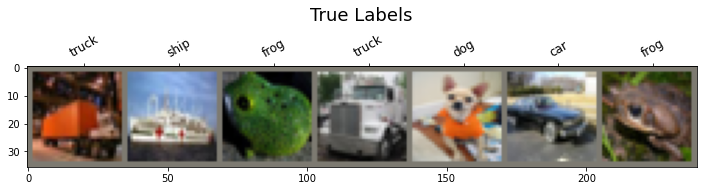

In [29]:
images, labels = dataiter.next()
imshow(images[:7], labels[:7])

### This function was made by Dr Prashant to train the model that's built above

In [30]:
# A function to encapsulate the training loop
def batch_gd(model, loss_fn, optimizer, train_loader, test_loader, epochs):
  model.to(device)
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    model.train()
    t0 = datetime.now()
    train_loss = []
    train_acc = []
    for inputs, targets in train_loader:
      # move data to GPU if available
      inputs, targets = inputs.to(device), targets.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # Forward pass
      outputs = model(inputs)
      __, out_label = outputs.max(dim=1)
      tr_acc = torch.sum(out_label == targets) / targets.size(0)
      loss = loss_fn(outputs, targets)
        
      # Backward and optimize
      loss.backward()
      optimizer.step()

      train_acc.append(tr_acc)
      train_loss.append(loss.item())

    # Get train loss and test loss
    train_loss = np.mean(train_loss) # a little misleading
    
    model.eval()
    test_loss = []
    for inputs, targets in test_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = model(inputs)
      loss = loss_fn(outputs, targets)
      __, out_label = outputs.max(dim=1)
      te_acc = torch.sum(out_label == targets) / targets.size(0)
      train_acc.append(te_acc)
      test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    # Save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss
    
    dt = datetime.now() - t0
    print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {(100*tr_acc):.3f} \
      Test Loss: {test_loss:.4f}, Test Accuracy: {(100*te_acc):.3f}, Duration: {dt}')
  
  return train_losses, test_losses

### Initializes the Transformer and selects the loss function and optimizer we want

In [31]:
model = ViT(
        img_size=32,          # Input image size
        in_channels=3,		# Number of channels for the image
        patch_size=4,         # How big our patches are
        embed_dim=42,		# Embedding dim
        n_layers=3,         # Number of transformer encoders
        n_heads=6,          # Number of attention heads
        attn_dropout=0.,       # Attention Dropout
        proj_dropout=0.,       # (MHA) Projection Dropout
        mlp_dropout=0.1,       # (MHA) last layer dropout
        mlp_ratio=4,           # (MHA) Projection FF dimension
        qkv_bias = True,
        n_classes=10       # Number of classes to classify
        )
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [32]:
train_losses, test_losses = batch_gd(model, loss_fn, optimizer, trainloader, testloader, epochs=3)

Epoch 1/3, Train Loss: 1.7321, Train Accuracy: 43.750       Test Loss: 1.4888, Test Accuracy: 43.750, Duration: 0:00:31.367054
Epoch 2/3, Train Loss: 1.4036, Train Accuracy: 42.500       Test Loss: 1.3308, Test Accuracy: 37.500, Duration: 0:00:30.704228
Epoch 3/3, Train Loss: 1.2701, Train Accuracy: 56.250       Test Loss: 1.2188, Test Accuracy: 56.250, Duration: 0:00:31.451279


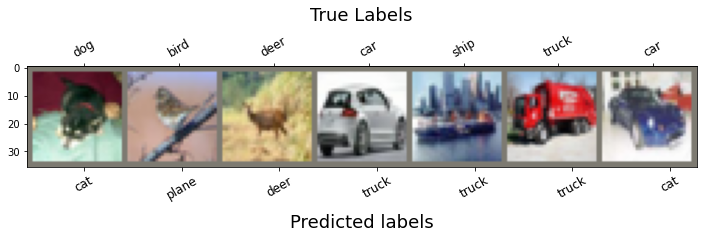

In [34]:
images, labels = test_dataiter.next()
out_img, predicted = torch.max(model(images.to(device)), 1)
imshow(images[:7], labels[:7], predicted[:7])